# Introduction

Cryptocurrencies are known for their high volatility, that may seem completely arbitrary. However, many cryptocurrencies fluctuate in accordance to another cryptocurrencies. As a high-level example, Ampleforth (AMPL) moves closely with Ethereum (ETH) because AMPL is built on the Ethereum Blockchain. Other patterns may not be as clear. Using datasets from Coinbase and Yahoo Finance, these correlations can easily be determined using the scripts below.

The correlation method used for this notebook is Pearson. The Pandas library has a built in function to determine the correlation. Nevertheless, it is important to understand how the algorithm works. In simple terms, the Pearson Correlation Coeffcient (PCC) is determined by taking the covariance of two lists, and dividing it by the product of the standard deviations of each list. A more procedural method of determining the PCC of two lists (**x** and **y**) is as follows:
1. Multiply each element of list **x** to the respective index element of list **y**. Let us call the list that contains these values **xy**.
2. Take the square of each element in list **x**. Let us call the list that contains these values **x2**.
3. Take the square of each element in list **y**. Let us call the list that contains these values **y2**.
4. Find the sum of all elements in the lists **x** and **y**. Let us call these values **sumx** and **sumy**, respectively.
5. Find the sum of all elements in the list **xy**. Let us call this value **sumxy**.
6. Find the sum of all elements in the lists **x2** and **y2**. Let us call these values **sumx2** and **sumy2**, respectively.
7. Find the difference between **sumxy** and the product of **sumx** and **sumy**. Let us call this value **cov**, as in covariance.
8. Find the standard deviation of list **x** by finding the difference between **sumx2** and the square of **sumx**. Let us call this value **stdx**.
9. Repeat Step 8 for list **y**. Let us call this value **stdy**.
10. Find the product of **stdx** and **stdy**. Let us call this value **std**.
11. Finally, divide **cov** by **std** to determine the PCC.

The PCC ranges from -1 to 1.
* As the PCC approaches 1, the correlation of the two lists increases.
* As the PCC approaches -1, the inverse correlation of the two lists increases.
* As the PCC approaches 0, the variance of the two lists increases. The higher the variance, the less the two lists are correlated.

## Important Notes

* To choose the crytocurrency pair you wish to analyze, initialize the variable in Cell 4.
* Yahoo Finance does not provide a complete list of product pairs and Coinbase does not provide the full historical data of a cryptocurrency. Using both, we are able to extract all coins accounted for by Coinbase, as well as the full historical data of each coin. **Only coins recognized by BOTH Yahoo Finance and Coinbase will work!**
* If you happen to run into an error saying that a particular cryptocurrency pair has been delisted from Yahoo Finance, simple append the trading pair to the list **coins_to_remove** in Cell 5.
* Changes and updates will be made to this notebook regularly.

# Implementation
## Step 1: Install libraries
* **yfinance** is used to access the historical data of a single cryptocurrency pair.
* **pandas** is used to handle large datasets using dataframes.
* **requests** is used to submit HTTP requests to Coinbase and receive the respective HTTP response.
* **matplotlib.pyplot** is used to visualize results to analyze.

In [1]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt

## Step 2: Implement function to determine the correlation of two coins

The **desired_coin_ticker** variable is the coin that the user wishes to compare correlations with. For example, if I wish to see how the price movements of Ethereum correlates with the price movements of all other cryptocurrencies, **desired_coin_ticker='ETH-USD'**. The **coin_list_ticker** variable is the ticker initialized when iterating through the list of all coins recognized by Coinbase (i.e., all other tickers aside from ETH-USD). Note that this is simply a function to be used later in the notebook.

In [2]:
def correlation(desired_coin_ticker, coin_list_ticker):
    
    # Download historical data of each ticker using Yahoo Finance
    desired_coin = yf.download(desired_coin_ticker, progress=False)
    desired_coin_df = pd.DataFrame(desired_coin)
    coin_list = yf.download(coin_list_ticker, progress=False)
    coin_list_df = pd.DataFrame(coin_list)
    
    # Set the start data of the historical data to the newer coin and update each dataframe.
    if desired_coin_df.index.values[0] > coin_list_df.index.values[0]:
        start_date = desired_coin_df.index.values[0]
    elif desired_coin_df.index.values[0] < coin_list_df.index.values[0]:
        start_date = coin_list_df.index.values[0]
    elif desired_coin_df.index.values[0] == coin_list_df.index.values[0]:
        start_date = coin_list_df.index.values[0]
    desired_coin_df = desired_coin_df[desired_coin_df.index >= start_date]
    coin_list_df = coin_list_df[coin_list_df.index >= start_date]
    
    # Export the "Open" prices of each ticker to a list. Verify the two lists are of equal length.
    desired_coin_prices = desired_coin_df["Open"].tolist()
    coin_list_prices = coin_list_df["Open"].tolist()
    if len(desired_coin_prices) > len(coin_list_prices):
        d = abs(len(desired_coin_prices) - len(coin_list_prices))
        desired_coin_prices = desired_coin_prices[d:]
    if len(desired_coin_prices) < len(coin_list_prices):
        d = abs(len(desired_coin_prices) - len(coin_list_prices))
        coin_list_prices = coin_list_prices[d:]
    
    # Import the two lists into a new dataframe.
    data = {desired_coin_ticker: desired_coin_prices, coin_list_ticker: coin_list_prices}
    df = pd.DataFrame(data=data)
    
    # Find the correlation of the dataframe using Pandas' corr() function.
    corr = df.corr()
    return corr[desired_coin_ticker].iloc[1]

## Step 3: Get a list of all coins

Using the **requests** package, an HTTP request is sent to Coinbase to receive a list of all cryptocurrencies recognized by Coinbase. However, these are simply the coin IDs, not the trading pairs. In order to make each ID a trading pair, '-USD' is appended to each ID. This list of pairs is then sorted in ascending alphabetic order.

In [3]:
# Get list of all known coins recognized by Coinbase.
url = "https://api.exchange.coinbase.com/currencies"
headers = {"Accept": "application/json"}
response = requests.get(url, headers=headers)
response = response.json()

# Append "-USD" to each coin ID to create a pair.
comp_coin_list = []
for i in response:
    comp_coin_list.append(i['id'])
for i in range(len(comp_coin_list)):
    comp_coin_list[i] = comp_coin_list[i] + "-USD"
comp_coin_list = sorted(comp_coin_list)

## Step 4: Initialize the variable with the coin you wish to compare

You may change 'ETH-USD' to which ever trading pair you desire. It must be paired with the fiat currency USD.

In [4]:
the_coin = "ETH-USD"

## Step 5: Remove coins not recognized by Yahoo Finance

Remove coins that are not listed on Yahoo Finance and the coin you are comparing against (i.e., the correlation of ETH-USD with itself is 1.0).

In [5]:
coins_to_remove = ['CGLD-USD', 'EUR-USD', 'GBP-USD', 'PAX-USD', 'USD-USD', the_coin]
for c in coins_to_remove:
    comp_coin_list.remove(c)

## Step 6: Determine the PCCs

These PCCs are aggregated into a dataframe in descending order. The cryptocurrencies with the most correlation to the desired coin is listed at the top. The cryptocurrencies with the most inverse correlation is listed at the bottom. The cryptocurrencies with little correlation is listed in the middle.

In [6]:
# Calculate correlations and append to a new list.
list_of_correlations = []
for i in range(len(comp_coin_list)):
    list_of_correlations.append(correlation(the_coin, comp_coin_list[i]))

# Use list to aggregate a final dataframe.
data = {'Pair': comp_coin_list, 'Correlation': list_of_correlations}
correlation_df = pd.DataFrame(data=data)
correlation_df.sort_values(by=['Correlation'], ascending=False, inplace=True)
correlation_df.reset_index(drop=True, inplace=True)
correlation_df

,Pair,Correlation
0,WAMPL-USD,0.948819
1,STX-USD,0.932125
2,OP-USD,0.928619
3,BTC-USD,0.927265
4,WBTC-USD,0.926182
...,...,...
198,DAI-USD,-0.349409
199,USDC-USD,-0.349833
200,APE-USD,-0.411201
201,DYP-USD,-0.445837


# Analysis
## Bar Plot of Most Correlated Cryptocurrencies

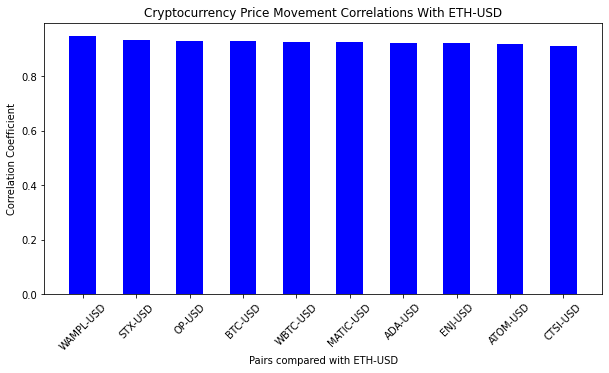

In [7]:
correlation_df_head = correlation_df.head(10)
pairs = correlation_df_head['Pair'].tolist()
correlations = correlation_df_head['Correlation'].tolist()
fig = plt.figure(figsize = (10, 5))

plt.bar(pairs, correlations, color='blue', width=0.5)
plt.xlabel("Pairs compared with " + the_coin)
plt.ylabel("Correlation Coefficient")
plt.title("Cryptocurrency Price Movement Correlations With " + the_coin)
plt.xticks(rotation=45)
plt.show()

## Bar Plot of Most Inversely Correlated Cryptocurrencies

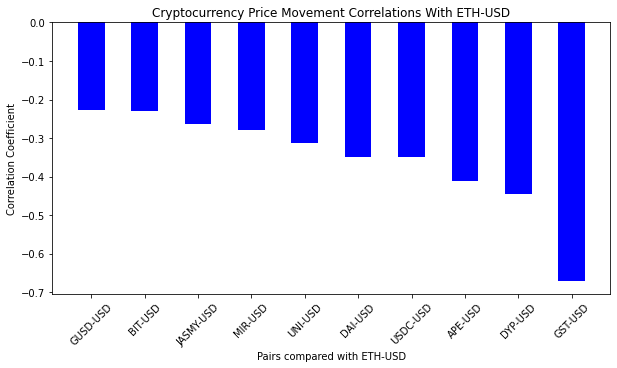

In [8]:
correlation_df_tail = correlation_df.tail(10)
pairs = correlation_df_tail['Pair'].tolist()
correlations = correlation_df_tail['Correlation'].tolist()
fig = plt.figure(figsize = (10, 5))

plt.bar(pairs, correlations, color='blue', width=0.5)
plt.xlabel("Pairs compared with " + the_coin)
plt.ylabel("Correlation Coefficient")
plt.title("Cryptocurrency Price Movement Correlations With " + the_coin)
plt.xticks(rotation=45)
plt.show()

# Final Words

These are open-source scripts and may be used as pleased (credit is appreciated). Feel free to share your own versions in the comments!